In [1]:
%load_ext autoreload
%autoreload 2

### Setup

In [2]:
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))
from utils import DATA_DIR, ROOT_DIR, PLOT_DIR

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from dataloader import get_nd_array, get_slice
from download.hf import pull_predictions_from_hf

import ladder_wrapper
plt.close()

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)  # ignore fitting warnings

In [ ]:
local_path = f'{DATA_DIR}/data/benchmarks-00000-of-00001.parquet'

In [4]:
df = pd.read_parquet(local_path)
print(f'Loaded {len(df):,} model evaluations')

# fix for the names of one of Ian's data mixes
df.loc[df['mix'] == 'baseline', 'mix'] = 'dolma17'

Loaded 810,570 model evaluations


In [5]:
def task_tag(task_name):
    return task_name.split("::")[0].replace(":rc", "") if "::" in task_name else task_name

MODELS = list(df['model'].unique())
MIXES = list(df['mix'].unique())
STEPS = list(df['step'].unique())
TASKS = sorted(list(df['task'].unique()))

In [6]:
from ladder_wrapper import sort_experiment_names
from download.preprocess import is_excluded_from_lite
from utils.constants_models import MODEL_LIST_MIXES
from utils.constants_models import DDOS_MODEL_NAMES

# Train models
all_ladder_models = [model for model in MODELS if 'peteish-moreeval' in model]
all_ladder_models = sort_experiment_names(all_ladder_models)

# Ladder config
ladder_config_path = f'{ROOT_DIR}/analysis/utils/ladder_config.json'

# Eval models
MODEL_LIST_MIXES = [model.split("/")[-1] for model in MODEL_LIST_MIXES]
BROKEN_MODELS = ["gemma-2b", "gemma-7b", "gemma-2-2b", "gemma-2-9b"] # gemma models broken in oe-eval
LLAMA_3_MODELS = [model for model in MODELS if 'Meta-Llama-3' in model]

all_models = sorted([model for model in MODELS if model not in DDOS_MODEL_NAMES + MODEL_LIST_MIXES + BROKEN_MODELS + all_ladder_models])

external_models = [model for model in all_models if not is_excluded_from_lite(model)]

### Select Tasks

In [7]:
selected_tasks = [
    t
    for t in TASKS
    if ":" not in t 
    and "bbh" not in t and "paloma" not in t and "llm_compression" not in t 
    and "custom_loss" not in t and "coqa" not in t and "deepmind" not in t
]

selected_tasks += [
    t
    for t in TASKS
    if ":mc" in t
    and "bbh" not in t and "paloma" not in t and "llm_compression" not in t
    and "custom_loss" not in t and "coqa" not in t and "deepmind" not in t
]

mmlu      = [t for t in TASKS if 'mmlu' in t and ':' not in t and '_pro_' not in t]
minerva   = [t for t in TASKS if 'minerva' in t and ':' not in t]
mmlu_pro  = [t for t in TASKS if '_pro_' in t and ':rc' in t]
mmlu_mc   = [t for t in TASKS if 'mmlu' in t and ':mc' in t and '_pro_' not in t]
olmes     = ['arc_challenge', 'arc_easy', 'boolq', 'csqa', 'hellaswag', 'openbookqa', 'piqa', 'socialiqa', 'winogrande']
olmes_mc  = [f'{task}:mc' for task in olmes]
olmes_para        = [f'{task}:para' for task in olmes]
olmes_distractors = [f'{task}:distractors' for task in olmes]
olmes_enlarge     = [f'{task}:enlarge' for task in olmes]
# olmes_gen = ['drop', 'gsm8k', 'jeopardy', 'naturalqs', 'squad', 'triviaqa']
olmes_gen = ['drop', 'gsm8k', 'jeopardy', 'squad', 'triviaqa']
agi_eval  = [t for t in TASKS if 'agi_eval' in t and ':rc' in t]
bbh       = [t for t in TASKS if 'bbh' in t and ':' not in t]
paloma    = [t for t in TASKS if 'paloma' in t]
llm_compression = [t for t in TASKS if 'llm_compression' in t]
custom_loss = [t for t in TASKS if 'custom_loss' in t]

# # # selected_tasks = olmes + olmes_gen + [olmes, olmes_para, olmes_distractors, olmes_enlarge, mmlu, olmes_mc, mmlu_mc, olmes_gen, minerva]
# # selected_tasks = olmes + olmes_gen + [olmes, mmlu, olmes_mc, mmlu_mc, olmes_gen, minerva]
# # selected_tasks += ['gsm_symbolic_main', mmlu_pro, 'autobencher', 'autobencher:mc']
# # # selected_tasks += ['minerva_math_500', 'mbpp', 'mbppplus', 'codex_humaneval', 'codex_humanevalplus', 'copycolors:mc']
# # selected_tasks += ['minerva_math_500', 'mbpp', 'mbppplus', 'codex_humaneval', 'codex_humanevalplus']

# # # selected_tasks = olmes + olmes_para + olmes_distractors + olmes_enlarge

multitask_math = ["gsm_plus", "gsm_symbolic_main", "gsm_symbolic_p1", "gsm_symbolic_p2", "minerva_math_500", "aime"] # 6
multitask_code = ['mbpp', 'mbppplus', 'codex_humaneval', 'codex_humanevalplus'] # 4
multitask_knowledge = ["medmcqa", 'autobencher'] + olmes + mmlu + olmes_gen + mmlu_pro + agi_eval # 19
multitask = multitask_knowledge + multitask_math + multitask_code + bbh # 30
olmes_all = olmes + mmlu + olmes_gen

olmes_all = ['jeopardy'] + list(set(olmes_all) - {'jeopardy'})
multitask = ['boolq'] + list(set(multitask) - {'boolq'})

# from utils import get_selected_tasks

# # selected_tasks = get_selected_tasks(TASKS)

# selected_tasks = [multitask_math, olmes_all]

In [8]:
from utils import get_title_from_task

def add_multitask_avg(df, task_set):
    _slice = get_slice(df, task=task_set)

    new_task = _slice.fillna('')
    new_task = new_task.groupby(['model', 'step', 'mix', 'size'])[['model_config', 'primary_score', 'logits_per_byte_corr', 'logits_per_char_corr']]
    new_task = new_task.agg(lambda x: x.iloc[0] if x.name == 'model_config' else x[pd.to_numeric(x, errors='coerce').notnull()].mean())
    new_task = new_task.reset_index()

    new_task['step'] = pd.to_numeric(new_task['step'], errors='coerce') 
    # new_task['size'] = pd.to_numeric(new_task['size'], errors='coerce')

    new_task['task'] = get_title_from_task(task_set)

    # Append the aggregate task entries to df
    df = pd.concat([df, new_task], axis=0)

    return df

# new task suites
multitask_math = ["gsm_plus", "gsm_symbolic_main", "gsm_symbolic_p1", "gsm_symbolic_p2", "minerva_math_500"] + ['gsm8k'] + ['minerva'] # 6 # "aime"
multitask_code = ['mbpp', 'mbppplus', 'codex_humaneval', 'codex_humanevalplus'] # 4
multitask_knowledge = ["medmcqa", 'autobencher'] + olmes + ['mmlu'] + olmes_gen + ['mmlu_pro'] + ['agi_eval'] # 19
multitask = multitask_knowledge + multitask_math + multitask_code # 30 # bbh
olmes_all = olmes + mmlu + olmes_gen

# Re-order tasks so that the title logic works (a bit hacky, yes)
olmes_all = ['jeopardy'] + list(set(olmes_all) - {'jeopardy'})
multitask = ['boolq'] + list(set(multitask) - {'boolq'})

df = add_multitask_avg(df, task_set=mmlu)
df = add_multitask_avg(df, task_set=mmlu_pro)
df = add_multitask_avg(df, task_set=agi_eval)
df = add_multitask_avg(df, task_set=minerva)
df = add_multitask_avg(df, task_set=multitask_math)
df = add_multitask_avg(df, task_set=multitask_code)
df = add_multitask_avg(df, task_set=multitask_knowledge)
df = add_multitask_avg(df, task_set=multitask)

selected_tasks = ['multitask_all', 'multitask_math', 'multitask_code', 'multitask_knowledge']

In [9]:
from ladder_wrapper import run_ladder
from metaanalysis import get_title_from_task, set_title_from_task
plt.close()

In [10]:
# Update model column to model_path for entries with -model-merged
    # last-29-model-merged => peteish7-last-29-model-merged
df["model_path"] = df["model_config"].apply(lambda x: x["model_path"])
mask = df['model_path'].str.contains('-model-merged', na=False)
df.loc[mask, 'model'] = df.loc[mask, 'model_path'].str.split('/').str[-2:].str.join('-')

In [11]:
merged_ladder_models = [
    f'{model}-last-6-model-merged' for model in all_ladder_models \
    if model not in ['peteish-moreeval-1B-10xC']
]

### Decisions using Avg. of Last $n$ Ckpts

In [12]:
from metaanalysis import construct_2class_table

In [13]:
def _run_ladder(task, model_name, last_n, last_n_method_train, last_n_method_eval, last_n_resample=None):
    _, (step_1_y, step_2_y, stacked_y), (step_1_y_pred, step_2_y_pred, stacked_y_pred) = run_ladder(
        df,
        task,
        # train_models=all_ladder_models + LLAMA_3_MODELS,
        train_models=all_ladder_models,
        eval_models=[model_name],
        config_path=ladder_config_path,
        run_step1=True, run_step2=True, run_stacked=True,
        return_reals=True,
        last_n=last_n, last_n_method_train=last_n_method_train, last_n_method_eval=last_n_method_eval,
        last_n_resample=last_n_resample
    )

    if last_n_resample is None:
        step_1_y = [step_1_y]
        step_1_y_pred = [step_1_y_pred]
        step_2_y = [step_2_y]
        step_2_y_pred = [step_2_y_pred]
        stacked_y = [stacked_y]
        stacked_y_pred = [stacked_y_pred]

    step1_abs_errors = []
    step1_rel_errors = []
    step2_abs_errors = []
    step2_rel_errors = []
    stacked_abs_errors = []
    stacked_rel_errors = []

    for i in range(len(stacked_y)):
        # Step 1
        y1, y1_pred = step_1_y[i], step_1_y_pred[i]
        abs_error = abs(y1 - y1_pred)
        rel_error = abs(y1 - y1_pred) / y1
        step1_abs_errors.append(abs_error)
        step1_rel_errors.append(rel_error)

        # Step 2
        y2, y2_pred = step_2_y[i], step_2_y_pred[i]
        abs_error = abs(y2 - y2_pred)
        rel_error = abs(y2 - y2_pred) / y2
        step2_abs_errors.append(abs_error)
        step2_rel_errors.append(rel_error)

        # Stacked
        assert len(stacked_y_pred[i]) == 1
        y, y_pred = stacked_y[i], stacked_y_pred[i][0]
        abs_error = abs(y - y_pred)
        rel_error = abs(y - y_pred) / y
        stacked_abs_errors.append(abs_error)
        stacked_rel_errors.append(rel_error)

    errors = {
        'step1': (np.mean(step1_abs_errors), np.mean(step1_rel_errors)),
        'step2': (np.mean(step2_abs_errors), np.mean(step2_rel_errors)), 
        'stacked': (np.mean(stacked_abs_errors), np.mean(stacked_rel_errors))
    }
    
    return errors

_run_ladder(
    task='arc_challenge', 
    model_name='peteish13-highlr', 

    # last_n=6, last_n_method_train='sample', last_n_method_eval='avg', last_n_resample=1000
    last_n=6, last_n_method_train='final', last_n_method_eval='avg'
    # last_n=6, last_n_method_train='avg', last_n_method_eval='final'
)

{'step1': (0.01676823411431616, 0.02543697393885967),
 'step2': (0.0634119601820089, 0.09783082580076494),
 'stacked': (0.08056766351789046, 0.12429833476476651)}

In [14]:
def ladder_variants(task, target_model):
    task_results = {}

    def add_results(task_results, prefix, results):
        task_results[f'{prefix}_step1_abs_error'] = results['step1'][0]
        task_results[f'{prefix}_step2_abs_error'] = results['step2'][0]
        task_results[f'{prefix}_stacked_abs_error'] = results['stacked'][0]
        task_results[f'{prefix}_step1_rel_error'] = results['step1'][1]
        task_results[f'{prefix}_step2_rel_error'] = results['step2'][1]
        task_results[f'{prefix}_stacked_rel_error'] = results['stacked'][1]
        return task_results

    # final ckpt of train + target
    results = _run_ladder(
        task=task, model_name=target_model, 
        # last_n=None, last_n_method_train=None, last_n_method_eval=None
        last_n=6, last_n_method_train='sample', last_n_method_eval='final', last_n_resample=1000
    )
    add_results(task_results, 'final_ckpt', results)

    # avg last n of train models
    results = _run_ladder(
        task=task, model_name=target_model, 
        # last_n=6, last_n_method_train='avg', last_n_method_eval='final'
        last_n=6, last_n_method_train='avg', last_n_method_eval='sample', last_n_resample=1000
    )
    add_results(task_results, 'avg_train', results)

    # avg last n of target models
    results = _run_ladder(
        task=task, model_name=target_model, 
        # last_n=6, last_n_method_train='final', last_n_method_eval='avg'
        last_n=6, last_n_method_train='sample', last_n_method_eval='avg', last_n_resample=1000
    )
    add_results(task_results, 'avg_target', results)

    # avg last n of train + target models
    results = _run_ladder(
        task=task, model_name=target_model, 
        last_n=6, last_n_method_train='avg', last_n_method_eval='avg'
    )
    add_results(task_results, 'avg_both', results)

    if target_model == 'peteish13-highlr':
        # final ckpt of train + weight space avg. target
        results = _run_ladder(
            task=task, model_name=f"{target_model}-last-30-model-merged", 
            last_n=None, last_n_method_train=None, last_n_method_eval=None
        )
        add_results(task_results, 'final_ckpt_weight_avg', results)

        # avg last n of train models + weight space avg. target
        results = _run_ladder(
            task=task, model_name=f"{target_model}-last-30-model-merged", 
            last_n=6, last_n_method_train='avg', last_n_method_eval='final'
        )
        add_results(task_results, 'avg_train_weight_avg', results)

    return task_results

# ladder_variants('arc_challenge', 'peteish13-highlr')
# ladder_variants('arc_easy', 'peteish13-highlr')
# ladder_variants('arc_easy', 'peteish7')
ladder_variants(mmlu, 'peteish13-highlr')

Computing ladder fits: 100%|██████████| 1000/1000 [00:08<00:00, 113.73it/s]


{'final_ckpt_step1_abs_error': 0.003268689697724181,
 'final_ckpt_step2_abs_error': 0.02178356721159003,
 'final_ckpt_stacked_abs_error': 0.019374217736854694,
 'final_ckpt_step1_rel_error': 0.004370354335566588,
 'final_ckpt_step2_rel_error': 0.04275524136397958,
 'final_ckpt_stacked_rel_error': 0.03802634102723039,
 'avg_train_step1_abs_error': 0.004929252580494597,
 'avg_train_step2_abs_error': 0.022573932402056907,
 'avg_train_stacked_abs_error': 0.017278415137779068,
 'avg_train_step1_rel_error': 0.006628785190767774,
 'avg_train_step2_rel_error': 0.04410982918271707,
 'avg_train_stacked_rel_error': 0.03375006500561907,
 'avg_target_step1_abs_error': 0.005482581239889803,
 'avg_target_step2_abs_error': 0.022236100259788897,
 'avg_target_stacked_abs_error': 0.01691666613175666,
 'avg_target_step1_rel_error': 0.007363760937804517,
 'avg_target_step2_rel_error': 0.043394347703972755,
 'avg_target_stacked_rel_error': 0.033013328935243676,
 'avg_both_step1_abs_error': 0.004890414750943

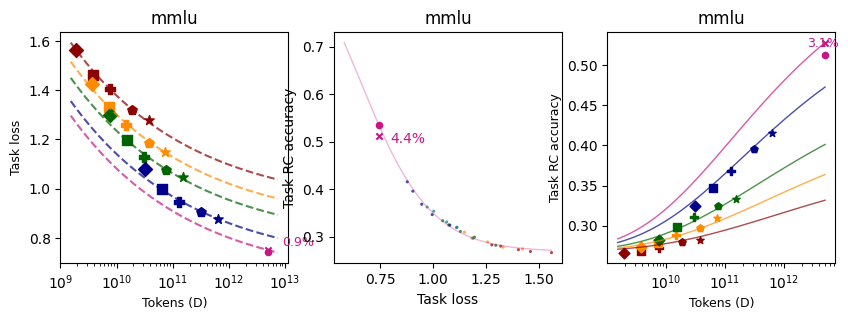

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3))

_, (step_1_y, step_2_y, stacked_y), (step_1_y_pred, step_2_y_pred, stacked_y_pred) = run_ladder(
    df,
    mmlu,
    # train_models=all_ladder_models + LLAMA_3_MODELS,
    train_models=all_ladder_models,
    eval_models=['peteish13-highlr'],
    config_path=ladder_config_path,
    run_step1=True, run_step2=True, run_stacked=True,
    return_reals=True,
    axes=axes,

    # last_n=6, last_n_method_train='avg', last_n_method_eval='avg',

    # last_n=6, last_n_method_train='sample', last_n_method_eval='avg',
    # last_n_resample=10
    
    last_n=6, last_n_method_train='final', last_n_method_eval='avg',
)

for ax in axes:
    ax.set_title('mmlu')
    ax.get_legend().remove()

plt.show()

In [16]:
# There are some duplicate evals for OLMo 2 7B. Only keep the first
df = df[~((df['model'] == 'peteish7') & (df['step'] == 928646.0) & df.duplicated(['model', 'step', 'task'], keep='first'))]

In [17]:
def decision_variants(task, size, small_metric, target_metric):
    result = {}

    two_class_sampled, _, _ = construct_2class_table(
        df, [task], 
        small_metric=small_metric, target_metric=target_metric,
        agg_method_pred='sample', # max_n, sample, mean
        agg_method_target='sample', # max_n, sample, mean
        model_sizes=[size]
    )
    avg_sampled_acc = np.mean(two_class_sampled[two_class_sampled['size'] == size]['accuracy'].values[0]) # mean of 1000 samples
    result.update({
        'acc_final': avg_sampled_acc, # avg neither
    })

    two_class_sampled, _, _ = construct_2class_table(
        df, [task], 
        small_metric=small_metric, target_metric=target_metric,
        agg_method_pred='mean', # max_n, sample, mean
        agg_method_target='sample', # max_n, sample, mean
        model_sizes=[size]
    )
    avg_sampled_acc = np.mean(two_class_sampled[two_class_sampled['size'] == size]['accuracy'].values[0]) # mean of 1000 samples
    result.update({
        'acc_target_avg': avg_sampled_acc, # avg just target
    })

    two_class_sampled, _, _ = construct_2class_table(
        df, [task], 
        small_metric=small_metric, target_metric=target_metric,
        agg_method_pred='sample', # max_n, sample, mean
        agg_method_target='mean', # max_n, sample, mean
        model_sizes=[size]
    )
    avg_sampled_acc = np.mean(two_class_sampled[two_class_sampled['size'] == size]['accuracy'].values[0]) # mean of 1000 samples
    result.update({
        'acc_pred_avg': avg_sampled_acc, # avg just prediction
    })

    two_class_mean, _, _ = construct_2class_table(
        df, [task], 
        small_metric=small_metric, target_metric=target_metric,
        agg_method_pred='mean', # max_n, sample, mean
        agg_method_target='mean', # max_n, sample, mean
        model_sizes=[size]
    )
    avg_last_n_acc = two_class_mean[two_class_mean['size'] == size]['accuracy'].values[0]
    result.update({
        'acc_both': avg_last_n_acc, # avg both
    })

    return result

decision_variants(
    # task='arc_challenge', 
    task=olmes,
    size='150M', 
    small_metric='primary_score', # logits_per_byte_corr
    target_metric='primary_score' # logits_per_byte_corr
)

{'acc_final': 0.7466933333333334,
 'acc_target_avg': 0.7429633333333334,
 'acc_pred_avg': 0.7389233333333333,
 'acc_both': 0.7366666666666667}

In [ ]:
# selected_tasks = olmes
# selected_tasks = ['arc_easy', 'arc_challenge']

# selected_tasks = olmes + olmes_gen # + [olmes, mmlu, olmes_gen, minerva]
# selected_tasks += ['gsm_symbolic_main', 'autobencher'] # mmlu_pro
# selected_tasks += ['minerva_math_500', 'mbpp', 'mbppplus', 'codex_humaneval', 'codex_humanevalplus']

# selected_tasks = [olmes, minerva, olmes_gen, mmlu, mmlu_pro, agi_eval, bbh] + olmes + olmes_gen + ['mbpp', 'mbppplus', 'codex_humaneval', 'codex_humanevalplus'] + ['autobencher'] + ["gsm_plus", "gsm_symbolic_main", "gsm_symbolic_p1", "gsm_symbolic_p2", "medmcqa", "minerva_math_500"] # aime

# selected_tasks = [multitask_math] # olmes_all

# selected_tasks = multitask_knowledge + ['multitask_all', 'multitask_math', 'multitask_code', 'multitask_knowledge']

from utils import get_selected_tasks

selected_tasks = get_selected_tasks(TASKS)
selected_tasks += ['multitask_all', 'multitask_math', 'multitask_code', 'multitask_knowledge']


size = '150M' # decision acc at 150M
target_model = 'peteish13-highlr' # prediction error at 13B

small_metric = target_metric = 'logits_per_byte_corr'
# small_metric = target_metric = 'primary_score'

ladder_results = []
decision_results_bpb = []
decision_results_primary = []
pbar = tqdm(enumerate(selected_tasks), total=len(selected_tasks))
for i, task in pbar:
    task_name = get_title_from_task(task)
    pbar.set_description(task_name)

    metadata = {}
    metadata['size'] = size
    metadata['task'] = task
    metadata['target_model'] = target_model

    ladder_result   = ladder_variants(task, target_model)
    decision_result_bpb = decision_variants(task, size, 'logits_per_byte_corr', 'logits_per_byte_corr')
    decision_result_primary = decision_variants(task, size, 'primary_score', 'primary_score')

    ladder_result.update(metadata)
    decision_result_bpb.update(metadata)
    decision_result_primary.update(metadata)

    ladder_results += [ladder_result]
    decision_results_bpb += [decision_result_bpb]
    decision_results_primary += [decision_result_primary]

In [37]:
ladder_results

[{'final_ckpt_step1_abs_error': 0.05169820453831855,
  'final_ckpt_step2_abs_error': 0.03421095392721176,
  'final_ckpt_stacked_abs_error': 0.07782307611463035,
  'final_ckpt_step1_rel_error': 0.05449561439399977,
  'final_ckpt_step2_rel_error': 0.08757920457620978,
  'final_ckpt_stacked_rel_error': 0.19922516975979118,
  'avg_train_step1_abs_error': 0.05401918544455911,
  'avg_train_step2_abs_error': 0.03417375545184797,
  'avg_train_stacked_abs_error': 0.07981074604780776,
  'avg_train_step1_rel_error': 0.05692825787438716,
  'avg_train_step2_rel_error': 0.08742891988533873,
  'avg_train_stacked_rel_error': 0.20412643840022232,
  'avg_target_step1_abs_error': 0.05090014218389054,
  'avg_target_step2_abs_error': 0.03437402233075436,
  'avg_target_stacked_abs_error': 0.07729154269248849,
  'avg_target_step1_rel_error': 0.05370926220728411,
  'avg_target_step2_rel_error': 0.08787117666095667,
  'avg_target_stacked_rel_error': 0.19758231192667303,
  'avg_both_step1_abs_error': 0.05375135

In [38]:
# Have all decision accuracy numbers be [0.5, 1]
decision_results_bpb = [
    {
        k: abs(v - 0.5) + 0.5 if isinstance(v, (int, float)) and k != "size" else v
        for k, v in result.items()
    }
    for result in decision_results_bpb
]

decision_results_primary = [
    {
        k: abs(v - 0.5) + 0.5 if isinstance(v, (int, float)) and k != "size" else v
        for k, v in result.items()
    }
    for result in decision_results_primary
]

In [69]:
from utils import get_pretty_task_name

decision_cols = {
    'task': 'Task',
    'acc_final': 'Final Ckpt',
    'acc_pred_avg': 'Avg. Prediction',
    'acc_target_avg': 'Avg. Target',
    'acc_both': 'Avg. Both',
}

ladder_cols = {
    'task': 'Task',
    # "avg_target_step1_abs_error": "Avg. Target Step 1 Abs. Error",
    # "avg_both_step1_abs_error": "Avg. Both Step 1 Abs. Error",
    # "avg_target_step2_abs_error": "Avg. Target Step 2 Abs. Error",
    # "avg_both_step2_abs_error": "Avg. Both Step 2 Abs. Error",
    "avg_target_stacked_abs_error": "Avg. Target Stacked Abs. Error",
    "avg_both_stacked_abs_error": "Avg. Both Stacked Abs. Error",
}

ladder_cols_large = {
    # "final_ckpt_step1_abs_error": "Final Ckpt Step 1 Abs. Error",
    # "avg_train_step1_abs_error": "Avg. Train Step 1 Abs. Error",
    "avg_target_step1_abs_error": "Avg. Target Step 1 Abs. Error",
    "avg_both_step1_abs_error": "Avg. Both Step 1 Abs. Error",

    # "final_ckpt_step1_rel_error": "Final Ckpt Step 1 Rel. Error",
    # "avg_train_step1_rel_error": "Avg. Train Step 1 Rel. Error",
    "avg_target_step1_rel_error": "Avg. Target Step 1 Rel. Error",
    "avg_both_step1_rel_error": "Avg. Both Step 1 Rel. Error",

    # "final_ckpt_step2_abs_error": "Final Ckpt Step 2 Abs. Error",
    # "avg_train_step2_abs_error": "Avg. Train Step 2 Abs. Error",
    # "avg_target_step2_abs_error": "Avg. Target Step 2 Abs. Error",
    # "avg_both_step2_abs_error": "Avg. Both Step 2 Abs. Error",

    # "final_ckpt_step2_rel_error": "Final Ckpt Step 2 Rel. Error",
    # "avg_train_step2_rel_error": "Avg. Train Step 2 Rel. Error",
    # "avg_target_step2_rel_error": "Avg. Target Step 2 Rel. Error",
    # "avg_both_step2_rel_error": "Avg. Both Step 2 Rel. Error",

    # "final_ckpt_stacked_abs_error": "Final Ckpt Stacked Abs. Error",
    # "avg_train_stacked_abs_error": "Avg. Train Stacked Abs. Error",
    "avg_target_stacked_abs_error": "Avg. Target Stacked Abs. Error",
    "avg_both_stacked_abs_error": "Avg. Both Stacked Abs. Error",
    
    # "final_ckpt_stacked_rel_error": "Final Ckpt Stacked Rel. Error",
    # "avg_train_stacked_rel_error": "Avg. Train Stacked Rel. Error",
    "avg_target_stacked_rel_error": "Avg. Target Stacked Rel. Error",
    "avg_both_stacked_rel_error": "Avg. Both Stacked Rel. Error",
    
    # "final_ckpt_weight_avg_step1_abs_error": "Final Ckpt Step 1 Abs. Error",
    # "final_ckpt_weight_avg_step2_abs_error": "Final Ckpt Step 2 Abs. Error",
    # "final_ckpt_weight_avg_stacked_abs_error": "Final Ckpt Stacked Abs. Error",
    # "final_ckpt_weight_avg_step1_rel_error": "Final Ckpt Step 1 Rel. Error",
    # "final_ckpt_weight_avg_step2_rel_error": "Final Ckpt Step 2 Rel. Error",
    # "final_ckpt_weight_avg_stacked_rel_error": "Final Ckpt Stacked Rel. Error",
    # "avg_train_weight_avg_step1_abs_error": "Avg. Train Step 1 Abs. Error",
    # "avg_train_weight_avg_step2_abs_error": "Avg. Train Step 2 Abs. Error",
    # "avg_train_weight_avg_stacked_abs_error": "Avg. Train Stacked Abs. Error",
    # "avg_train_weight_avg_step1_rel_error": "Avg. Train Step 1 Rel. Error",
    # "avg_train_weight_avg_step2_rel_error": "Avg. Train Step 2 Rel. Error",
    # "avg_train_weight_avg_stacked_rel_error": "Avg. Train Stacked Rel. Error",
}

def _format_df(results, sort_col, col_names, bold_best=True):
    df_results = pd.DataFrame(results)

    # Delete cols
    df_results = df_results.drop(['size', 'target_model'], axis=1)

    if 'error' in sort_col:
        sort_ascending = True
    elif 'acc' in sort_col:
        sort_ascending = False
    else:
        raise ValueError()
    
    # Sort
    ordered_cols = ['task'] + [c for c in col_names.keys() if c in df_results.columns and c != 'task']
    df_results = df_results[ordered_cols]
    df_results = df_results.sort_values(sort_col, ascending=sort_ascending)

    # display(df_results)

    # if 'error' in sort_col:
    #     df_results = df_results[df_results[sort_col] <= 0.1]

    # Add average row
    avg_row = pd.Series({'task': 'Average'})
    for col in df_results.columns:
        if col == 'task':
            continue
        values = df_results[col]
        avg_row[col] = values.mean()
    df_results = pd.concat([df_results, avg_row.to_frame().T], ignore_index=True)

    # Convert to percentages
    percentage_cols = [col for col in df_results.columns if col != 'task']
    df_results[percentage_cols] = (df_results[percentage_cols] * 100)
   
    # Bold the max of each row
    for idx in df_results.index:
        row_vals = df_results.loc[idx, percentage_cols]
        for col in percentage_cols:
            val = df_results.loc[idx, col]

            if sort_ascending:
                best_val = row_vals.min()
                is_best_row = val == best_val
                all_best = (np.round(row_vals, 2) == np.round(best_val, 2)).sum() == len(row_vals)
            else:
                best_val = row_vals.max() 
                is_best_row = val == best_val
                # print(row_vals.to_numpy())
                # print(np.round(row_vals.to_numpy(), 2))
                TOL = 0.01
                is_max = np.abs(best_val - row_vals.to_numpy()) < TOL
                all_best = (is_max).sum() == len(row_vals)
                # print(all_best)

            if is_best_row and bold_best and not all_best:
                df_results.loc[idx, col] = f'$\\mathbf{{{val:.2f}}}$'
            else:
                df_results.loc[idx, col] = f'${val:.2f}$'
                
            df_results.loc[idx, 'all_best'] = all_best

            # df_results.loc[idx, col] = f'{val:.1f}%'

    # Rename columns and tasks
    df_results['task'] = df_results['task'].apply(get_pretty_task_name)
    df_results = df_results.rename(columns=col_names)

    # Add "*" to tasks with same value for all tasks
    # df_results.loc[df_results['all_best'], 'Task'] = df_results.loc[df_results['all_best'], 'Task'] + '*'
    df_results = df_results.drop('all_best', axis=1)

    return df_results

df_ladder       = _format_df(ladder_results, sort_col='avg_both_stacked_abs_error', col_names=ladder_cols)
df_ladder_large = _format_df(ladder_results, sort_col='avg_both_stacked_abs_error', col_names=ladder_cols_large, bold_best=False)
df_decision_bpb = _format_df(decision_results_bpb, sort_col='acc_both', col_names=decision_cols)
df_decision_primary = _format_df(decision_results_primary, sort_col='acc_both', col_names=decision_cols)

# display(df_decision_primary)
# display(df_decision_bpb)
display(df_ladder)
# display(df_ladder_large)

Task does not have pretty name: Average
Task does not have pretty name: Average
Task does not have pretty name: Average
Task does not have pretty name: Average


Task Avg. Target Stacked Abs. Error  \
0         HumanEval+                         $1.05$   
1          HellaSwag                         $0.31$   
2      CommonsenseQA                         $0.59$   
3           Jeopardy                         $0.57$   
4          SocialIQA                $\mathbf{0.50}$   
5          All Tasks                         $1.03$   
6       Minerva MATH                         $1.08$   
7               PIQA                $\mathbf{0.89}$   
8    Knowledge Tasks                         $1.43$   
9               MMLU                $\mathbf{1.68}$   
10          MMLU Pro                         $1.76$   
11  Minerva MATH 500                        $17.35$   
12              MBPP                         $2.57$   
13          AGI Eval                $\mathbf{1.89}$   
14         OLMES Gen                         $4.19$   
15        Math Tasks                        $11.33$   
16             BoolQ                         $4.13$   
17      OLMES Core 9                $\mathbf{2.47}$   
18          TriviaQA                $\mathbf{2.33}$   
19        Code Tasks                         $3.15$   
20             SQuAD                         $2.80$   
21        OpenBookQA                         $4.02$   
22   GSM Symbolic P2                         $7.46$   
23       AutoBencher                         $3.86$   
24             GSM8K                         $7.46$   
25          ARC Easy                         $5.13$   
26           MedMCQA                $\mathbf{7.72}$   
27     ARC Challenge                         $8.44$   
28             MBPP+                         $9.08$   
29         HumanEval                $\mathbf{7.71}$   
30        WinoGrande               $\mathbf{10.01}$   
31              GSM+                        $29.14$   
32               BBH                        $33.09$   
33              DROP               $\mathbf{35.17}$   
34      GSM Symbolic                        $39.88$   
35   GSM Symbolic P1               $\mathbf{27.15}$   
36           Average                $\mathbf{8.29}$   

   Avg. Both Stacked Abs. Error  
0               $\mathbf{0.04}$  
1               $\mathbf{0.16}$  
2               $\mathbf{0.46}$  
3               $\mathbf{0.54}$  
4                        $0.59$  
5               $\mathbf{0.86}$  
6               $\mathbf{0.98}$  
7                        $1.01$  
8               $\mathbf{1.20}$  
9                        $1.74$  
10              $\mathbf{1.75}$  
11              $\mathbf{1.78}$  
12              $\mathbf{1.79}$  
13                       $1.98$  
14              $\mathbf{2.16}$  
15              $\mathbf{2.30}$  
16              $\mathbf{2.48}$  
17                       $2.62$  
18                       $2.62$  
19              $\mathbf{2.75}$  
20              $\mathbf{2.79}$  
21              $\mathbf{3.38}$  
22              $\mathbf{3.50}$  
23              $\mathbf{3.69}$  
24              $\mathbf{3.85}$  
25              $\mathbf{5.13}$  
26                       $7.98$  
27              $\mathbf{8.43}$  
28              $\mathbf{8.79}$  
29                       $8.85$  
30                      $10.82$  
31             $\mathbf{28.54}$  
32             $\mathbf{33.08}$  
33                      $35.20$  
34             $\mathbf{38.88}$  
35                      $83.62$  
36                       $8.79$

In [71]:
def _format_latex(df):
    CAPTION = "Caption goes here"
    table_str = df.to_latex(
        label="tab:avg-last-n",
        index=False, 
        float_format=lambda x: '%.2f' % x,
        column_format='p{0.12\\textwidth}' + 'C{0.05\\textwidth}'*len(df.columns)
    )
    table_str = table_str.replace('%', '\%')
    table_str = table_str.replace('table', 'table*')\
        .replace('\\begin{table*}', '\\begin{table*}\n\\tiny\n\\centering\n\\makebox[\\textwidth]{')\
        .replace('\\end{table*}', '}\n\\caption{' + CAPTION + '}\n\\end{table*}')
    table_str = table_str.replace('Average', '\\midrule\nAverage')
    
    return table_str

print(_format_latex(df_ladder))
# print(_format_latex(df_ladder_large))
# print(_format_latex(df_decision_primary))
# print(_format_latex(df_decision_bpb))

\begin{table*}
\tiny
\centering
\makebox[\textwidth]{
\label{tab:avg-last-n}
\begin{tabular}{p{0.12\textwidth}C{0.05\textwidth}C{0.05\textwidth}C{0.05\textwidth}}
\toprule
Task & Avg. Target Stacked Abs. Error & Avg. Both Stacked Abs. Error \\
\midrule
HumanEval+ & $1.05$ & $\mathbf{0.04}$ \\
HellaSwag & $0.31$ & $\mathbf{0.16}$ \\
CommonsenseQA & $0.59$ & $\mathbf{0.46}$ \\
Jeopardy & $0.57$ & $\mathbf{0.54}$ \\
SocialIQA & $\mathbf{0.50}$ & $0.59$ \\
All Tasks & $1.03$ & $\mathbf{0.86}$ \\
Minerva MATH & $1.08$ & $\mathbf{0.98}$ \\
PIQA & $\mathbf{0.89}$ & $1.01$ \\
Knowledge Tasks & $1.43$ & $\mathbf{1.20}$ \\
MMLU & $\mathbf{1.68}$ & $1.74$ \\
MMLU Pro & $1.76$ & $\mathbf{1.75}$ \\
Minerva MATH 500 & $17.35$ & $\mathbf{1.78}$ \\
MBPP & $2.57$ & $\mathbf{1.79}$ \\
AGI Eval & $\mathbf{1.89}$ & $1.98$ \\
OLMES Gen & $4.19$ & $\mathbf{2.16}$ \\
Math Tasks & $11.33$ & $\mathbf{2.30}$ \\
BoolQ & $4.13$ & $\mathbf{2.48}$ \\
OLMES Core 9 & $\mathbf{2.47}$ & $2.62$ \\
TriviaQA & $\mathbf{2.

In [62]:
# (for appendix) Remove asterisks from Task column before merging
df_decision_primary['Task'] = df_decision_primary['Task'].str.replace('*', '')
df_decision_bpb['Task'] = df_decision_bpb['Task'].str.replace('*', '')

# Merge the dataframes on Task column
df_combined = pd.merge(df_decision_bpb, df_decision_primary, on='Task', suffixes=('_bpb', '_primary'))

df_combined

Task    Final Ckpt_bpb Avg. Prediction_bpb   Avg. Target_bpb  \
0         Code Tasks           $96.67$             $96.67$           $96.67$   
1         HumanEval+           $96.33$             $96.33$           $96.33$   
2          HumanEval           $95.67$             $95.67$           $95.67$   
3               MBPP           $95.33$             $95.33$           $95.33$   
4      ARC Challenge           $94.56$    $\mathbf{94.88}$           $94.38$   
5          HellaSwag           $92.42$             $93.19$           $93.21$   
6              MBPP+           $93.00$             $93.00$           $93.00$   
7           ARC Easy  $\mathbf{92.23}$             $92.15$           $91.96$   
8               MMLU           $91.53$             $91.64$           $91.63$   
9   Minerva MATH 500           $90.33$             $90.33$           $90.33$   
10      Minerva MATH           $90.00$             $90.00$           $90.00$   
11       AutoBencher           $88.55$             $88.95$           $89.19$   
12          MMLU Pro           $90.00$             $89.40$  $\mathbf{90.04}$   
13        Math Tasks           $88.33$             $88.33$           $88.33$   
14          AGI Eval           $86.38$             $86.75$           $86.54$   
15           MedMCQA           $86.67$             $86.67$           $86.67$   
16          Jeopardy           $84.42$             $84.46$           $84.88$   
17          TriviaQA           $83.55$             $84.29$           $83.86$   
18        OpenBookQA           $81.53$             $81.75$           $81.68$   
19   GSM Symbolic P1           $81.33$             $81.33$           $81.33$   
20      OLMES Core 9           $79.05$             $80.10$           $79.32$   
21   GSM Symbolic P2           $79.67$             $79.67$           $79.67$   
22         SocialIQA  $\mathbf{79.92}$             $79.57$           $79.45$   
23              GSM+           $79.00$             $79.00$           $79.00$   
24      GSM Symbolic           $78.33$             $78.33$           $78.33$   
25             GSM8K           $76.67$             $76.67$           $76.67$   
26        WinoGrande           $73.20$    $\mathbf{74.29}$           $72.83$   
27              PIQA           $72.60$    $\mathbf{72.91}$           $71.93$   
28   Knowledge Tasks           $71.39$             $71.49$           $71.62$   
29         All Tasks           $68.57$             $70.63$           $69.78$   
30     CommonsenseQA           $65.86$    $\mathbf{66.25}$           $65.42$   
31             BoolQ           $63.72$    $\mathbf{64.19}$           $63.51$   
32             SQuAD           $60.93$             $60.59$  $\mathbf{62.02}$   
33         OLMES Gen  $\mathbf{61.16}$             $55.44$           $55.11$   
34              DROP           $56.67$             $56.48$  $\mathbf{57.46}$   
35               BBH           $57.48$             $57.25$  $\mathbf{57.66}$   
36           Average           $81.20$             $81.22$           $81.13$   

       Avg. Both_bpb Final Ckpt_primary Avg. Prediction_primary  \
0            $96.67$   $\mathbf{85.67}$        $\mathbf{85.67}$   
1            $96.33$   $\mathbf{71.33}$        $\mathbf{71.33}$   
2            $95.67$   $\mathbf{80.00}$        $\mathbf{80.00}$   
3            $95.33$   $\mathbf{76.00}$        $\mathbf{76.00}$   
4            $94.67$            $82.91$                 $82.27$   
5   $\mathbf{94.00}$            $71.05$                 $71.26$   
6            $93.00$   $\mathbf{70.67}$        $\mathbf{70.67}$   
7            $92.00$            $93.96$                 $93.99$   
8   $\mathbf{91.67}$            $89.08$                 $88.84$   
9            $90.33$   $\mathbf{51.00}$        $\mathbf{51.00}$   
10           $90.00$            $51.00$                 $51.00$   
11  $\mathbf{89.67}$            $88.80$        $\mathbf{89.05}$   
12           $89.33$            $83.34$                 $83.77$   
13           $88.33$            $42.6

In [63]:
print(_format_latex(df_combined))

\begin{table*}
\tiny
\centering
\makebox[\textwidth]{
\label{tab:avg-last-n}
\begin{tabular}{p{0.12\textwidth}C{0.05\textwidth}C{0.05\textwidth}C{0.05\textwidth}C{0.05\textwidth}C{0.05\textwidth}C{0.05\textwidth}C{0.05\textwidth}C{0.05\textwidth}C{0.05\textwidth}}
\toprule
Task & Final Ckpt_bpb & Avg. Prediction_bpb & Avg. Target_bpb & Avg. Both_bpb & Final Ckpt_primary & Avg. Prediction_primary & Avg. Target_primary & Avg. Both_primary \\
\midrule
Code Tasks & $96.67$ & $96.67$ & $96.67$ & $96.67$ & $\mathbf{85.67}$ & $\mathbf{85.67}$ & $\mathbf{85.67}$ & $80.33$ \\
HumanEval+ & $96.33$ & $96.33$ & $96.33$ & $96.33$ & $\mathbf{71.33}$ & $\mathbf{71.33}$ & $\mathbf{71.33}$ & $66.00$ \\
HumanEval & $95.67$ & $95.67$ & $95.67$ & $95.67$ & $\mathbf{80.00}$ & $\mathbf{80.00}$ & $\mathbf{80.00}$ & $74.33$ \\
MBPP & $95.33$ & $95.33$ & $95.33$ & $95.33$ & $\mathbf{76.00}$ & $\mathbf{76.00}$ & $\mathbf{76.00}$ & $68.33$ \\
ARC Challenge & $94.56$ & $\mathbf{94.88}$ & $94.38$ & $94.67$ & $82.9